# Pairwise Comparison for Single Environment

In this file we do a pairwise comparison for policies trained in a single environment but using different seeds and/or training algorithms.

We look at:

- Self-play
- Cross-play between policies trained with the same algorithm but different seeds
- Cross-play between policies trained with different algorithms


## Notation

- **Self-play** refers to pairings of policies that trained together
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import os.path as osp
from typing import List, Any, Optional, Tuple
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
from plot_utils import heatmap, annotate_heatmap

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

In [19]:
rl_policies_results_dir_name = 'pairwise_comparison_initseed0_numseeds1_2022-06-27_00-28-38pmhho7pe'
# rl_policies_results_dir_name = 'pairwise_comparison_2022-06-05_04-27-5926t_11oa'
# 'pairwise_comparison_2022-06-03_01-05-585go1wtxv'     
# '2022-05-29 03:19:51.564867'
rl_policies_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, rl_policies_results_dir_name, "compiled_results.csv")
rl_df = pd.read_csv(rl_policies_results_file)

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones', 
    # 'num_outcome_LOSS', 
    # 'num_outcome_DRAW', 
    # 'num_outcome_WIN', 
    # 'num_outcome_NA'
]
rl_df = rl_df.drop(columns_to_drop, axis=1)

# Add 95% CI
def conf_int(row, prefix):
    std = row[f"{prefix}_std"]
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))


def add_95CI(df):
    prefix = ""
    for col in df.columns:
        if not col.endswith("_std"):
            continue
        prefix = col.replace("_std", "")
        df[f"{prefix}_CI"] = df.apply(lambda row: conf_int(row, prefix), axis=1)
    return df


def prop(row, col_name):
    n = row["num_episodes"]
    total = row[col_name]
    return total / n


def add_prop(df):
    prop_cols = ['num_outcome_LOSS', 'num_outcome_DRAW', 'num_outcome_WIN', 'num_outcome_NA']
    prop_names = ["prop_LOSS", "prop_DRAW", "prop_WIN", "prop_NA"]
    for col_name, new_name in zip(prop_cols, prop_names):
        if col_name in df.columns:
            df[new_name] = df.apply(lambda row: prop(row, col_name), axis=1)
    return df

rl_df = add_95CI(rl_df)
rl_df = add_prop(rl_df)
rl_df.columns

Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes',
       'use_checkpointing', 'policy_name', 'policy_dir', 'policy_id',
       'episode_returns_mean', 'episode_returns_std', 'episode_returns_max',
       'episode_returns_min', 'episode_discounted_returns_mean',
       'episode_discounted_returns_std', 'episode_discounted_returns_max',
       'episode_discounted_returns_min', 'episode_steps_mean',
       'episode_steps_std', 'episode_times_mean', 'episode_times_std',
       'num_outcome_LOSS', 'num_outcome_DRAW', 'num_outcome_WIN',
       'num_outcome_NA', 'episode_returns_CI', 'episode_discounted_returns_CI',
       'episode_steps_CI', 'episode_times_CI', 'prop_LOSS', 'prop_DRAW',
       'prop_WIN', 'prop_NA'],
      dtype='object')

In [20]:
rl_df["policy_dir"].unique()

array(['/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_klr_Driving7x7RoundAbout-v0_k4_seed2_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_klr_Driving7x7RoundAbout-v0_k4_seed0_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_klr_Driving7x7RoundAbout-v0_k4_seed3_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_klr_Driving7x7RoundAbout-v0_k4_seed4_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_klr_Driving7x7RoundAbout-v0_k4_seed1_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_sp_Driving7x7RoundAbout-v0_seed0_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_policies/2022-06-01/train_sp_Driving7x7RoundAbout-v0_seed2_2022-06-01',
       '/home/remote/u1078789/baposgmcp_results/Driving/rl_poli

In [21]:
def rename_policy_dir(row):
    policy_dir = row["policy_dir"]
    policy_dir = osp.basename(osp.normpath(policy_dir))
    if policy_dir.startswith("Driving7x7RoundAbout-v0_SP"):
        seed = int(policy_dir.split("_")[2])
        timestamp = policy_dir.split("_")[3]
        policy_dir = f"train_sp_Driving7x7RoundAbout-v0_seed={seed}_{timestamp}"
    return policy_dir

rl_df["policy_dir"] = rl_df.apply(rename_policy_dir, axis=1)
policy_dirs = rl_df["policy_dir"].unique()
policy_dirs.sort()

policy_dirs


array(['train_klr_Driving7x7RoundAbout-v0_k4_seed0_2022-06-01',
       'train_klr_Driving7x7RoundAbout-v0_k4_seed1_2022-06-01',
       'train_klr_Driving7x7RoundAbout-v0_k4_seed2_2022-06-01',
       'train_klr_Driving7x7RoundAbout-v0_k4_seed3_2022-06-01',
       'train_klr_Driving7x7RoundAbout-v0_k4_seed4_2022-06-01',
       'train_sp_Driving7x7RoundAbout-v0_seed0_2022-06-01',
       'train_sp_Driving7x7RoundAbout-v0_seed1_2022-06-01',
       'train_sp_Driving7x7RoundAbout-v0_seed2_2022-06-01',
       'train_sp_Driving7x7RoundAbout-v0_seed3_2022-06-01',
       'train_sp_Driving7x7RoundAbout-v0_seed4_2022-06-01'], dtype=object)

In [22]:
def get_k(row):
    pi_name = row["policy_name"]
    if "Random" in pi_name:
        return str(-1)
    if "BAPOSGMCP" in pi_name:
        return "BA"
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")
        

def parse_policy_directory(policy_dir: str):
    """Returns (alg, env_name, seed, alg_kwargs)."""
    if policy_dir in (None, 'None', np.nan):
        # random or some other fixed policy
        return 'None', 'None', 'None', {}
    
    # get only final directory in path
    policy_dir = osp.basename(osp.normpath(policy_dir))
    
    # expect 'train_<alg>_<env_name>_[algkwargs_]seed<int>_<timestamp>'
    tokens = policy_dir.split("_")
    alg = tokens[1].lower()
    env_name = tokens[2]
    
    seed = 'None'
    for t in tokens:
        if "seed=" in t:
            # for backward compatibility with old naming style
            seed = int(t.split("=")[1])
            break
        elif "seed" in t:
            seed = int(t.replace("seed", ""))
            break
    
    if alg == "klr":
        # expect 'train_<alg>_<env_name>_k=<k>_[seed=int]_<timestamp>'
        if "k=" in tokens[3]:
            k = int(tokens[3].split("=")[1])
        elif "k" in tokens[3]:
            k = int(tokens[3].replace("k", ""))
        else:
            raise AssertionError(f"Bad policy dir format: {policy_dir}")
        alg_kwargs = {"k": k}
    else:
        alg_kwargs = {}

    return alg, env_name, seed, alg_kwargs

        
def get_train_properties(row):
    if "policy_dir" not in row:
        return 'None', 'None', 'None'
    return parse_policy_directory(row["policy_dir"])


def get_train_alg(row):
    return get_train_properties(row)[0]


def get_train_env(row):
    return get_train_properties(row)[1]


def get_train_seed(row):
    return get_train_properties(row)[2]
    

rl_df["K"] = rl_df.apply(get_k, axis=1)
rl_df["train_env_name"] = rl_df.apply(get_train_env, axis=1)
rl_df["train_seed"] = rl_df.apply(get_train_seed, axis=1)
rl_df["train_alg"] = rl_df.apply(get_train_alg, axis=1)

# Plotting

For this evaluation we have multiple degrees of variation:

1. Policy reasoning level ('K') - the reasoning level of an agent policy 
  - `BR` is the best response policy for a distribution over the policies `[-1, 0, 1, 2, 3, 4]`
  - `SP` is the policy trained using the `self-play` algorithm.
2. Train Seeds ('train_seed') - the training seed of the agent policy
  - 5 different seeds were used for each experiment
3. Training algorithm ('train_alg') - The algorithm used to train the agent policy
  - `KLR` - K-level reasoning algorithm (specifically the SyKLRBR algorithm)
  - `SP` - self-play


In [23]:
# some sanity tests
test_envs = rl_df["env_name"].unique()
train_envs = rl_df["train_env_name"].unique()
assert len(test_envs) == 1
assert len(train_envs) == 1
test_env = test_envs[0]
train_env = train_envs[0]
assert test_env == train_env

agent_ids = rl_df["agent_id"].unique()
agent_ids.sort()
assert len(agent_ids) == 2
agent_0_id = agent_ids[0]
agent_1_id = agent_ids[1]

print("Test Env:", test_env)
print("Train Envs:", train_env)
print("Agent IDs:", agent_ids)
print("Policy K:", rl_df["K"].unique())
print("Train Seeds:", rl_df["train_seed"].unique())
print("Train Algorithms:", rl_df["train_alg"].unique())


Test Env: Driving7x7RoundAbout-v0
Train Envs: Driving7x7RoundAbout-v0
Agent IDs: [0 1]
Policy K: ['0' '3' '1' 'BR' 'SP' '4' '2' '-1']
Train Seeds: [2 0 3 4 1]
Train Algorithms: ['klr' 'sp']


## The environment

Here we can see the layout for the environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

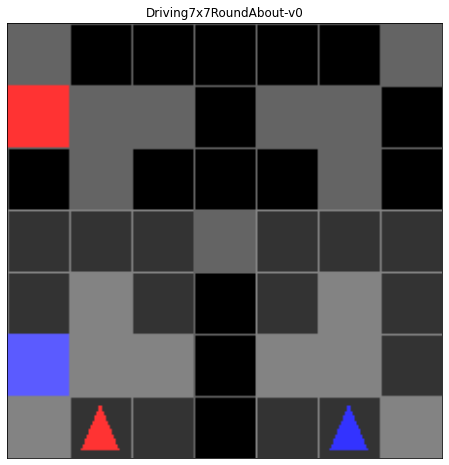

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
# Turn off x/y axis numbering/ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])

env = posggym.make(test_env)
env_img, _ = env.render(mode='rgb_array')

imshow_obj = ax.imshow(
    env_img, interpolation='bilinear', origin='upper'
)
imshow_obj.set_data(env_img)

ax.set_title(test_env)
    
plt.show()
    

## Helper Functions

The following are some helper functions for later plots.

In [26]:
def filter_by(df, conds):
    """Filters dataframe by given conditions.
    
    Removes any rows that do not meet the conditions.
    """
    query_strs = []
    for (k, op, v) in conds:
        if isinstance(v, str):
            q = f"({k} {op} '{v}')"
        else:
            q = f"({k} {op} {v})"
        query_strs.append(q)  
    query = " & ".join(query_strs)
    
    filtered_df = df.query(query)
    return filtered_df

def filter_exps_by(df, conds):
    """Filters experiment in dataframe by given conditions.
    
    Ensures all rows for an experiment where any row of that experiment
    meets the conditions are in the resulting dataframe.
    
    Removes any rows that do not meet the conditions and are not part of
    an experiment where at least one row (i.e. agent) meets the condition.
    """
    filtered_df = filter_by(df, conds)
    exp_ids = filtered_df["exp_id"].unique()
    df = df[df["exp_id"].isin(exp_ids)]
    return df

In [27]:
def get_pw_values(plot_df,
                  row_conds: List,
                  row_seed_key: str,
                  col_conds: List,
                  col_seed_key: str,
                  y_key: str) -> Tuple[List, List, np.ndarray]:
    """Get pairwise values of y variable between two variables (row_seed_key, col_seed_key).
    
    Constrains each row and col with additional conditions.
    """
    row_df = filter_by(plot_df, row_conds)
    row_seeds = row_df[row_seed_key].unique()
    row_seeds.sort()
    
    col_df = filter_by(plot_df, col_conds)
    col_seeds = col_df[col_seed_key].unique()
    col_seeds.sort()

    pw_values = np.zeros((len(row_seeds), len(col_seeds)))

    for c, c_seed in enumerate(col_seeds):
        for r, r_seed in enumerate(row_seeds):
            ys = []
            for (a0, a1) in permutations(agent_ids):
                c_seed_conds = col_conds + [("agent_id", "==", a0), (col_seed_key, "==", c_seed)]
                c_seed_df = filter_exps_by(plot_df, c_seed_conds)
                
                r_seed_conds = row_conds + [("agent_id", "==", a1), (row_seed_key, "==", r_seed)]
                r_seed_df = filter_by(c_seed_df, r_seed_conds)

                y = r_seed_df[y_key].tolist()
                if len(y) > 0:
                    ys.extend(y)
    
            if len(ys) == 0:
                # do this so we can see where error is
                y = np.nan
            else:
                # might have more than a single value since we can have
                # the same (row_val, col_val) pairing for each permutation of agents
                y = np.mean(ys)
            pw_values[r][c] = y
    
    return (row_seeds, col_seeds), pw_values


def get_mean_pw_values(plot_df,
                       row_conds: List,
                       row_seed_key: str,
                       row_alg_key: str,
                       col_conds: List,
                       col_seed_key: str,
                       col_alg_key: str,
                       y_key: str) -> Tuple[float, float]:
    """Get pairwise mean values of y variable (y_key) over seeds
        
    Note this involves taking:
    - for each row_seed - get the average value for each col_seed
    - take average of row_seed averages
    
    Outputs:
    1. mean for self-play ((row_alg, row_seed) == (col_alg, col_seed)), may be np.nan
    2. mean for cross-play
    """
    seeds, pw_returns = get_pw_values(
        plot_df, 
        row_conds=row_conds, 
        row_seed_key=row_seed_key,
        col_conds=col_conds,
        col_seed_key=col_seed_key,
        y_key=y_key
    )
    
    row_df = filter_by(plot_df, row_conds)
    row_alg = row_df[row_alg_key].unique().tolist()
    assert len(row_alg) == 1
    row_alg = row_alg[0]
    
    col_df = filter_by(plot_df, col_conds)
    col_alg = col_df[col_alg_key].unique().tolist()
    assert len(col_alg) == 1
    col_alg = col_alg[0]
    
    xp_values = []
    sp_values = []
    for r, row_seed in enumerate(seeds[0]):
        for c, col_seed in enumerate(seeds[1]):
            v = pw_returns[r][c]
            if np.isnan(v):
                continue
            if (row_alg, row_seed) == (col_alg, col_seed):
                sp_values.append(v)
            else: 
                xp_values.append(v)
    if row_alg != col_alg:
        # cross-play only
        return np.nan, np.mean(xp_values)
    return np.mean(sp_values), np.mean(xp_values)

In [29]:
def get_all_rl_pw_mean_values(plot_df, y_key: str):
    policy_IDs = plot_df["K"].unique()
    policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))
    sp_pw_returns = np.zeros((len(policy_IDs), len(policy_IDs)))

    for r, row_policy_id in enumerate(policy_IDs):
        for c, col_policy_id in enumerate(policy_IDs):
            sp_return, xp_return = get_mean_pw_values(
                plot_df,
                row_conds=[("K", "==", row_policy_id)],
                row_seed_key="train_seed",
                row_alg_key="train_alg",
                col_conds=[("K", "==", col_policy_id)],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return policy_IDs, sp_pw_returns, xp_pw_returns

In [55]:
def plot_pw_heatmap(ax,
                    pi_labels,
                    pw_values,
                    title=None,
                    vrange=None,
                    valfmt=None):
    # Note numpy arrays by default have (0, 0) in the top-left corner
    # While matplotlib images are displayed with (0, 0) being the bottom-left corner
    # To get images looking correct we need to reverse the rows of the array
    # And also the row labels
    # pw_returns = pw_returns.T
    pw_values = pw_values[-1::-1]
    
    if vrange is None:
        vrange = (-0.2, 1.0)
    if valfmt is None:
        valfmt = "{x:.2f}"
    
    im, cbar = heatmap(
        data=pw_values, 
        row_labels=reversed(pi_labels[0]),
        col_labels=pi_labels[1],
        ax=ax,
        show_cbar=False,
        cmap="viridis",
        vmin=vrange[0],
        vmax=vrange[1]
    )
    texts = annotate_heatmap(
        im, 
        valfmt=valfmt,
        textcolors=("white", "black"),
        threshold=vrange[0]+(0.2*(vrange[1] - vrange[0]))
    )
    if title:
        ax.set_title(title)

In [66]:
def plot_pairwise_policy_comparison(plot_df, 
                                    y_key: str,
                                    vrange=None,
                                    figsize=(20, 20),
                                    valfmt=None):
    """Plot results for each policy-seed pairings.
    
    This produces a grid of (grid)-plots:
    
    Outer-grid: train seed X train seed
    Inner-grid: K X K
    
    """
    train_seeds = plot_df["train_seed"].unique()
    train_seeds.sort()
    
    policy_ids = plot_df["K"].unique()
    policy_ids.sort()
    
    row_agent_id = 0
    col_agent_id = 1
    
    fig, axs = plt.subplots(nrows=len(train_seeds), ncols=len(train_seeds), figsize=(20, 20))
    for row_seed_idx, row_seed in enumerate(train_seeds):
        for col_seed_idx, col_seed in enumerate(train_seeds):
            pw_values = np.zeros((len(policy_ids), len(policy_ids)))
            
            for col_policy_idx, col_policy_id in enumerate(policy_ids):
                col_policy_df = filter_exps_by(
                        plot_df,
                        [
                            ("agent_id", "==", col_agent_id), 
                            ("train_seed", "==", col_seed),
                            ("K", "==", col_policy_id)
                        ]
                )
                for row_policy_idx, row_policy_id in enumerate(policy_ids):
                    pairing_df = filter_by(
                        col_policy_df,
                        [
                            ("agent_id", "==", row_agent_id), 
                            ("train_seed", "==", row_seed),
                            ("K", "==", row_policy_id)
                        ]
                    )
                    pairing_y_vals = pairing_df[y_key].unique()
                    pairing_y_vals.sort()
                    
                    if len(pairing_y_vals) == 0:
                        y = np.nan
                    elif len(pairing_y_vals) == 1:
                        y = pairing_y_vals[0]
                    else:
                        print("More than 1 experiment found for pairing:")
                        print(f"({row_policy_id}, {row_seed}) vs ({col_policy_id}, {col_seed}): {pairing_y_vals}")
                        print("Plotting only the first value.")
                        y = pairing_y_vals[1]
                        
                    if y is not np.nan and valfmt is None:
                        if isinstance(y, float):
                            valfmt = "{x:.2f}"
                        if isinstance(y, int):
                            valfmt = "{x}"
                    
                    pw_values[row_policy_idx][col_policy_idx] = y
            
            ax = axs[row_seed_idx][col_seed_idx]
            plot_pw_heatmap(ax, (policy_ids, policy_ids), pw_values, title=None, vrange=vrange, valfmt=valfmt)
            
            if row_seed_idx == 0:
                ax.set_title(col_seed_idx)
            if col_seed_idx == 0:
                ax.set_ylabel(row_seed_idx)
                    

In [64]:
def plot_rl_pw_comparison(plot_df, y_key: str, vrange: Optional[Tuple[float, float]] = None):
    policy_ids, sp_values, xp_values = get_all_rl_pw_mean_values(plot_df, y_key)
    
    if vrange is None:
        min_value = np.nanmin([np.nanmin(sp_values), np.nanmin(xp_values)])
        max_value = np.nanmax([np.nanmax(sp_values), np.nanmax(xp_values)])
        vrange = (min_value, max_value)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
    plot_pw_heatmap(axs[0], (policy_ids, policy_ids), sp_values, title=f"Same-Play")
    plot_pw_heatmap(axs[1], (policy_ids, policy_ids), xp_values, title=f"Cross-Play")

    pw_diff = sp_values - xp_values
    plot_pw_heatmap(
        axs[2], 
        (policy_ids, policy_ids), 
        pw_diff, 
        title=f"Difference", 
        vrange=(np.nanmin(pw_diff), np.nanmax(pw_diff))
    )

    fig.tight_layout()
    fig.suptitle(y_key)
    # fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", "pw_rl_performance.png"))
    plt.show()

## RL Pairwise Policy Performance

Here we look at the performance for each possible pairing of (policy_id, train_seed).

For each performance metric we have a grid of (grid)-plots:
    
- Outer-grid: train seed X train seed
- Inner-grid: policy_id X policy_id

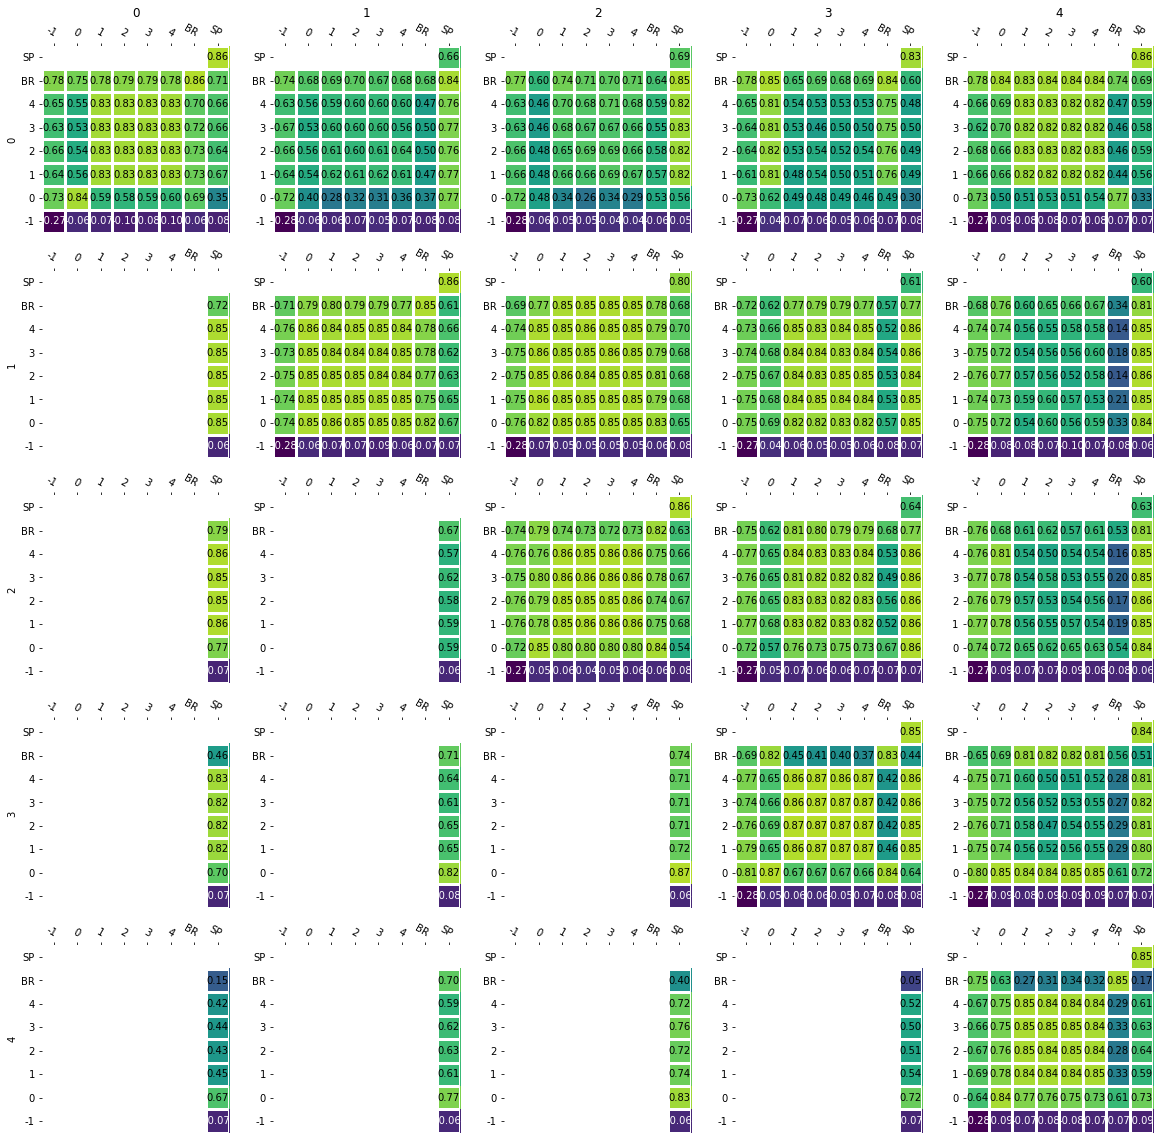

In [67]:
plot_pairwise_policy_comparison(
    rl_df, y_key="episode_discounted_returns_mean", vrange=(-0.2, 1.0), figsize=(20, 20), valfmt="{x:.2f}"
)

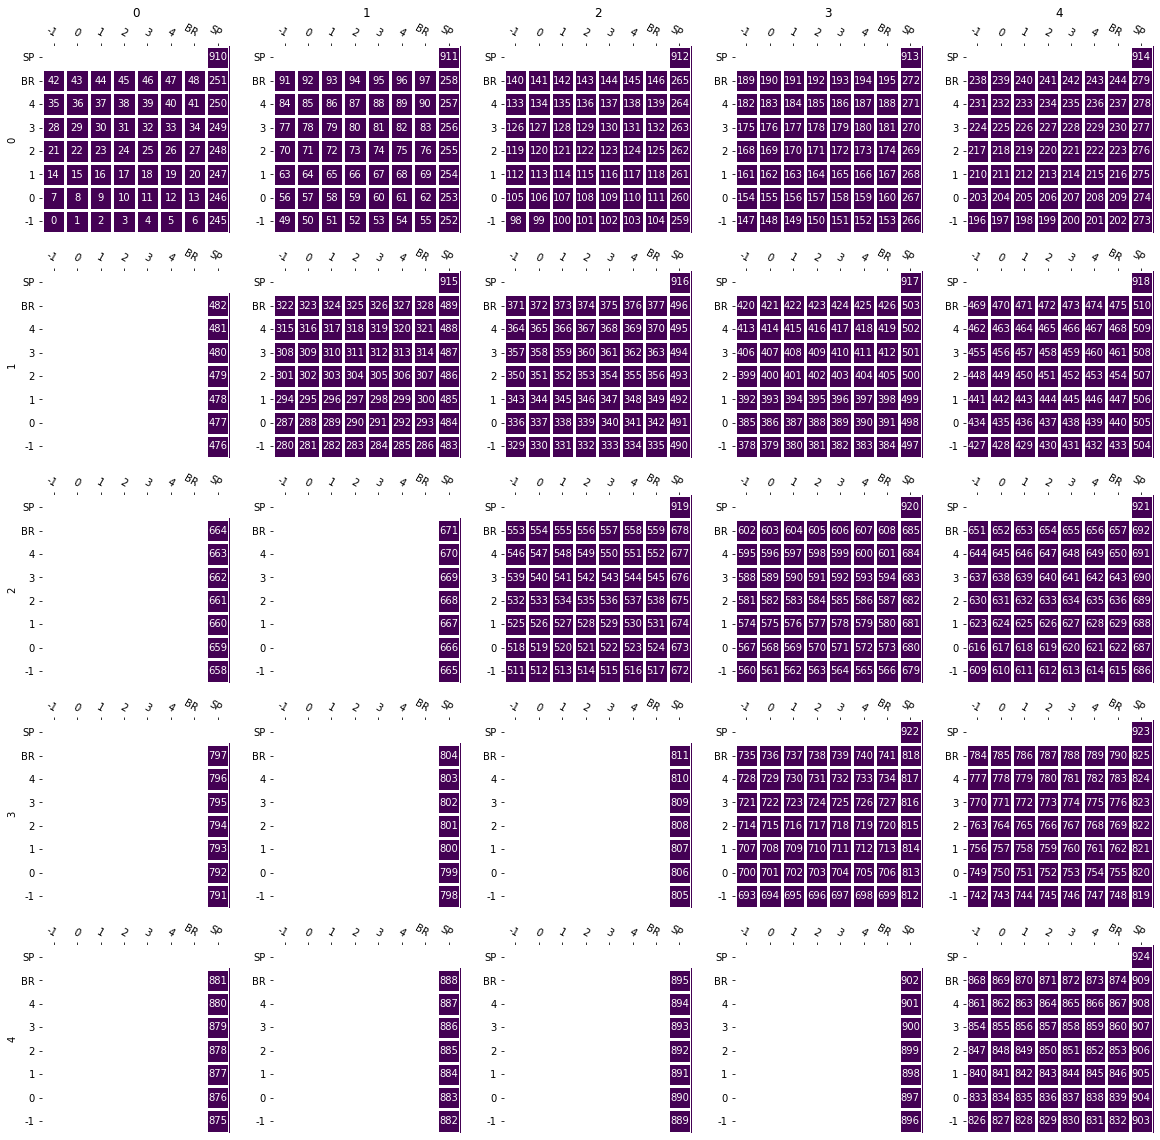

In [69]:
plot_pairwise_policy_comparison(rl_df, y_key="exp_id", vrange=(0.0, 0.0), figsize=(20, 20), valfmt="{x:.0f}")

## RL average policy performance

Here look at average performance of the policies learned using RL by themselves (without additional search).

Each plot shows the *mean discounted episode return* for the *row* policy against the *column* policy.

The **left-hand plot** shows *same-play* performance. So performance of policies against policies from the same training population (same training algorithm and same seed).

The **middle plot** shows *cross-play* performance. So performance of policies against policies from different training populations (against policies trained using a different algorithm and/or different seed).

The **right-hand plot** shows the generalization gap which is just the difference between the *Same-Play* and *Cross-Play* performance.

<__array_function__ internals>:180: UserWarning: Warning: converting a masked element to nan.
/home/jonathon/miniconda3/envs/ba-posgmcp/lib/python3.8/site-packages/matplotlib/colors.py:1211: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/jonathon/miniconda3/envs/ba-posgmcp/lib/python3.8/site-packages/matplotlib/ticker.py:380: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


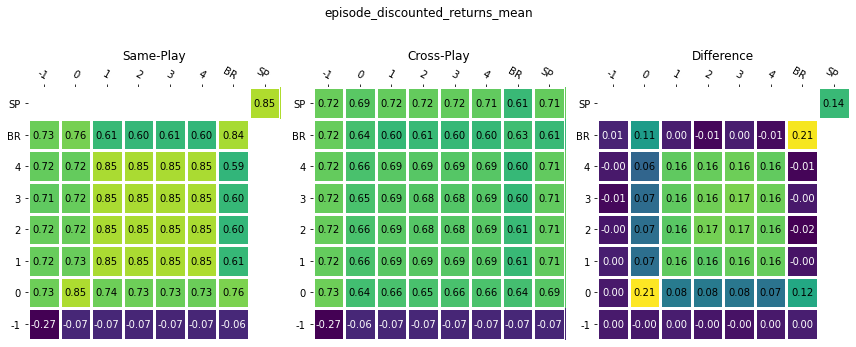

In [33]:
plot_rl_pw_comparison(
    rl_df, "episode_discounted_returns_mean", vrange=(-0.2, 1.0)
)
plt.show()

The next set of plots show the *Proportion of episodes the row agent reached it's goal*. I.e. the success rate.

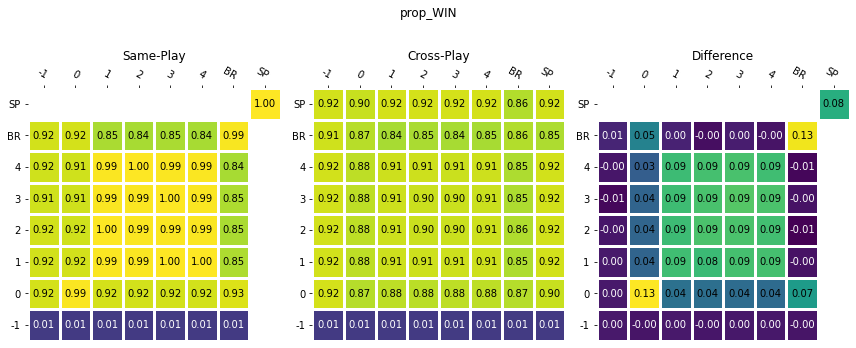

In [34]:
plot_rl_pw_comparison(rl_df, "prop_WIN", vrange=(0.0, 1.0))
plt.show()

The next set of plots show the *Proportion of episodes the row agent crashed*. I.e. the collision rate.

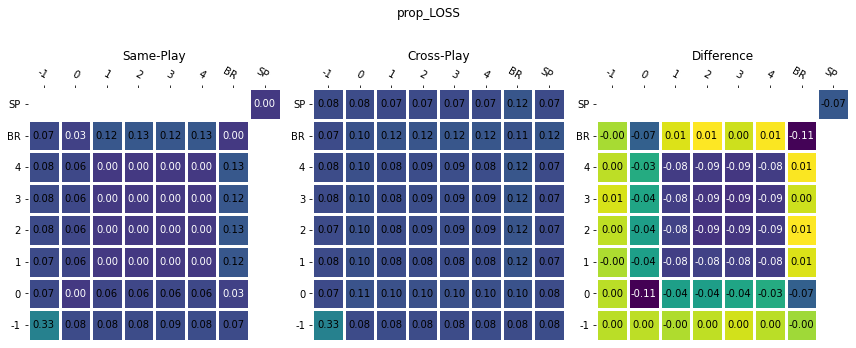

In [35]:
plot_rl_pw_comparison(rl_df, "prop_LOSS", vrange=(0.0, 0.4))
plt.show()

# BAPOSGMCP performance

In this section we evaluate the BAPOSGMCP algorithm which adds online MCTS search on top of the trained RL policies.

### Helper functions

The next few code blocks contain functions for plotting and cleaning data.

In [17]:
# maps BAPOSGMCP other agent policy K to rollout policy ID
ba_rollout_policy_map = {
    "klr": "pi_BR",
    "sp": "pi_SP",
    'none': "pi_-1"
}


ba_columns_to_drop = [
    "Unnamed: 0.1",
    "Unnamed: 0",
    "args",
    "seed",
    "episode_step_limit",
    "time_limit",
]

ba_unused_stats = [
    "reinvigoration_time_mean",
    "reinvigoration_time_std",
    "inference_time_mean",
    "inference_time_std",
    "policy_calls_mean",
    "policy_calls_std",
#     "search_time_mean",
#     "search_time_std",
#     "update_time_mean",
#     "update_time_std",
    "episode_returns_mean",
    "episode_returns_std",
    "episode_returns_max",
    "episode_returns_min",
    "episode_discounted_returns_max",
    "episode_discounted_returns_min",
    "episode_dones",
]

ba_hyperparameters = [
    "other_policy_prior",
    "truncated",
    "c_init",
    "c_base",
    "reinvigorator",
    "extra_particles_prop",
    "step_limit",
    "epsilon",
]

def get_rollout_k(row):
    pi_name = row["rollout_id"]
    if "Random" in pi_name:
        return str(-1)
    if "BAPOSGMCP" in pi_name:
        return "BA"
    if pi_name == 'None':
        return 'None'
    try:
        return pi_name.split("_")[-1]
    except Exception:
        raise Exception("Policy name error")


# Some useful data cleaning functions
def get_rollout_policy_properties(row):
    """Returns (policy_ID, alg, env_name, seed, alg_kwargs)."""
    if row["K"] != "BA":
        return 'None', 'None', 'None', 'None', {}
    
    alg, env_name, seed, alg_kwargs = parse_policy_directory(row["rollout_policy_dir"])
    rollout_policy_id = ba_rollout_policy_map[alg]
    return rollout_policy_id, alg, env_name, seed, alg_kwargs


def get_other_policies_properties(row):
    """Returns (alg, env_name, seed, alg_kwargs)."""
    if row["K"] != "BA":
        return 'None', 'None', 'None', {}
    return parse_policy_directory(row["other_agent_policy_dir"])


def get_rollout_policy_id(row):
    return get_rollout_policy_properties(row)[0]


def get_rollout_policy_alg(row):
    return get_rollout_policy_properties(row)[1]


def get_rollout_policy_seed(row):
    return get_rollout_policy_properties(row)[3]


def get_other_agent_alg(row):
    return get_other_policies_properties(row)[0]


def get_other_agent_seed(row):
    return get_other_policies_properties(row)[2]

In [18]:
ba_results_dir_name = 'baposgmcp_exp_all_2022-06'
ba_results_file = osp.join(exp_utils.EXP_RESULTS_DIR, ba_results_dir_name, "compiled_results.csv")
ba_df = pd.read_csv(ba_results_file)

ba_df = ba_df.drop(ba_columns_to_drop, axis=1)
ba_df = ba_df.drop(ba_unused_stats, axis=1)
ba_df = add_95CI(ba_df)
ba_df = add_prop(ba_df)

ba_df["K"] = ba_df.apply(get_k, axis=1)
ba_df["train_seed"] = ba_df.apply(get_train_seed, axis=1)
ba_df["train_alg"] = ba_df.apply(get_train_alg, axis=1)

ba_df["rollout_id"] = ba_df.apply(get_rollout_policy_id, axis=1)
ba_df["rollout_K"] = ba_df.apply(get_rollout_k, axis=1)
ba_df["rollout_seed"] = ba_df.apply(get_rollout_policy_seed, axis=1)
ba_df["rollout_alg"] = ba_df.apply(get_rollout_policy_alg, axis=1)

ba_df["other_alg"] = ba_df.apply(get_other_agent_alg, axis=1)
ba_df["other_seed"] = ba_df.apply(get_other_agent_seed, axis=1)

print(ba_df.columns)
# for c in ba_df.columns:
#    print(f'"{c}",')

Index(['Unnamed: 0.2', 'exp_id', 'agent_id', 'env_name', 'num_episodes',
       'policy_name', 'other_policy_prior', 'num_sims', 'c_init', 'c_base',
       'truncated', 'reinvigorator', 'extra_particles_prop', 'step_limit',
       'epsilon', 'policy_id', 'other_agent_policy_dir', 'rollout_policy_ids',
       'rollout_policy_dir', 'policy_dir', 'bayes_accuracy_0',
       'bayes_accuracy_1', 'search_time_mean', 'search_time_std',
       'update_time_mean', 'update_time_std',
       'episode_discounted_returns_mean', 'episode_discounted_returns_std',
       'episode_steps_mean', 'episode_steps_std', 'episode_times_mean',
       'episode_times_std', 'num_outcome_LOSS', 'num_outcome_DRAW',
       'num_outcome_WIN', 'num_outcome_NA', 'search_time_CI', 'update_time_CI',
       'episode_discounted_returns_CI', 'episode_steps_CI', 'episode_times_CI',
       'prop_LOSS', 'prop_DRAW', 'prop_WIN', 'prop_NA', 'K', 'train_seed',
       'train_alg', 'rollout_id', 'rollout_K', 'rollout_seed', 'rollout

In [19]:
# some sanity tests
def ba_sanity_test(df):
    test_envs = df["env_name"].unique()
    assert len(test_envs) == 1
    test_env = test_envs[0]

    agent_ids = df["agent_id"].unique()
    agent_ids.sort()
    assert len(agent_ids) == 2
    agent_0_id = agent_ids[0]
    agent_1_id = agent_ids[1]
    
    num_entries = len(df)
    num_exps = len(df["exp_id"].unique())
    assert num_entries == 2*num_exps

    print("Test Env:", test_env)
    print("Agent IDs:", agent_ids)
    print("Policy K:", df["K"].unique())
    print("Policy Names:", df["policy_name"].unique())
    print("Train Seeds:", df["train_seed"].unique())
    print("Train Algorithms:", df["train_alg"].unique())

    print("Num rows/entries:", num_entries)
    print("Num experiments:", num_exps)
        
    ba_only_df = df[df["policy_name"] == "BAPOSGMCP_0"]
    print("\nBAPOSGMCP Hyperparameters")
    print("Num sims:", ba_only_df["num_sims"].unique())
    
    print("Rollout Policy K:", ba_only_df["rollout_K"].unique())
    print("Rollout Policy IDs:", ba_only_df["rollout_id"].unique())
    print("Rollout Policy Seeds:", ba_only_df['rollout_seed'].unique())
    print("Rollout Policy Algs:", ba_only_df['rollout_alg'].unique())
    
    print("Other Agent Policies Algs:", ba_only_df['other_alg'].unique())
    print("Other Agent Policies Seeds:", ba_only_df['other_seed'].unique())
    
    for c in ba_hyperparameters:
        values = ba_only_df[c].unique()
        values.sort()
        if len(values) > 1:
            print(f"{c}:", values[0], "+ other values")
        else:
            print(f"{c}:", values[0])
    
ba_sanity_test(ba_df)

Test Env: Driving7x7RoundAbout-v0
Agent IDs: [0 1]
Policy K: ['BA' '4' '-1' '3' 'BR' '1' '2' '0' 'SP']
Policy Names: ['BAPOSGMCP_0' 'PPOPolicy_pi_4' 'RandomPolicy' 'PPOPolicy_pi_3'
 'PPOPolicy_pi_BR' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2' 'PPOPolicy_pi_0'
 'PPOPolicy_pi_SP']
Train Seeds: ['None' 3 0 2 4 1]
Train Algorithms: ['None' 'klr' 'sp']
Num rows/entries: 6220
Num experiments: 3110

BAPOSGMCP Hyperparameters
Num sims: ['1024' '512' '256' '128' '64' '32' '16' '8']
Rollout Policy K: ['SP' 'BR']
Rollout Policy IDs: ['pi_SP' 'pi_BR']
Rollout Policy Seeds: [0 4 2 3 1]
Rollout Policy Algs: ['sp' 'klr']
Other Agent Policies Algs: ['sp' 'klr']
Other Agent Policies Seeds: [0 4 2 3 1]
other_policy_prior: None
truncated: True
c_init: 1.0
c_base: 100.0
reinvigorator: <baposgmcp.tree.reinvigorate.BABeliefRejectionSampler object at 0x7eea0dbe9790> + other values
extra_particles_prop: 0.0625
step_limit: 50
epsilon: 0.01


In [20]:
def get_all_mean_ba_pw_values(plot_df, y_key: str):
    """Get pairwise mean values for num_sims vs coplayer policy.
    
    This will be for a specific rollout policy.
    """
    ba_only_df = filter_by(plot_df, [("K", "==", "BA")])
    assert len(ba_only_df["rollout_K"].unique().tolist()) == 1

    num_sims = ba_only_df["num_sims"].unique().tolist()
    num_sims = [int(n) for n in num_sims]
    num_sims.sort()
#     print(f"{num_sims=}")

    ba_coplayer_df = plot_df[plot_df["K"] != "BA"]
    coplayer_K = ba_coplayer_df["K"].unique().tolist()
    coplayer_K.sort()
#     print(f"{coplayer_K=}")
    
    xp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))
    sp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))

    for r, r_num_sims in enumerate(num_sims):
        for c, cp_K in enumerate(coplayer_K):
#             print(f"  {r=} {r_num_sims=}")
#             print(f"  {c=} {cp_K=}")
            rc_plot_df = filter_exps_by(plot_df, [("K", "==", "BA"), ("num_sims", "==", str(r_num_sims))])
            rc_plot_df = filter_exps_by(rc_plot_df, [("K", "==", cp_K)])
            
            # Checks
            ba_only_df = rc_plot_df[rc_plot_df["K"] == "BA"]
            assert len(ba_only_df["num_sims"].unique()) <= 1
            if len(ba_only_df["num_sims"].unique()) == 0:
                print(f"Missing data for {r=} {r_num_sims=} {c=} {cp_K=}")
                continue
            
            cp_only_df = rc_plot_df[rc_plot_df["K"] != "BA"]
            assert len(cp_only_df["K"].unique()) == 1
            
            sp_return, xp_return = get_mean_pw_values(
                rc_plot_df,
                row_conds=[("K", "==", "BA")],
                row_seed_key="rollout_seed",
                row_alg_key="rollout_alg",
                col_conds=[("K", "!=", "BA")],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (num_sims, coplayer_K), sp_pw_returns, xp_pw_returns


In [39]:
def plot_ba_values_by_rollout_K(plot_df, 
                                y_key: str, 
                                include_rl_comparison: bool, 
                                plot_rl_df: Optional,
                                vrange: Optional[Tuple[float, float]] = None,
                                figsize: Optional[Tuple[int, int]] = None):
    """Plot self-play and cross-play values against num sims for different 
    BA rollout policies.
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    rl_Ks, rl_sp_values, rl_xp_values = [], None, None
    if include_rl_comparison:
        rl_Ks, rl_sp_values, rl_xp_values = get_all_rl_pw_mean_values(plot_rl_df, y_key)
        rl_Ks = rl_Ks.tolist()
        print(f"{rl_Ks=}")
    
    ncols = 2
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (ncols*4, nrows*3)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = filter_exps_by(ba_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(
            ba_df_r_k, 
            y_key=y_key
        )

        row_labels = row_num_sims
        col_labels = row_cp_Ks
        if include_rl_comparison and rollout_K in rl_Ks:
            # add performance of Rollout policy to the table
            assert row_cp_Ks == rl_Ks
            rollout_K_idx = rl_Ks.index(rollout_K)
            rollout_K_sp_values = rl_sp_values[rollout_K_idx]
            rollout_K_xp_values = rl_xp_values[rollout_K_idx]

            row_sp_values = np.vstack([row_sp_values, rollout_K_sp_values])
            row_xp_values = np.vstack([row_xp_values, rollout_K_xp_values])
            row_labels.append(rollout_K)
        
        if vrange is None:
            min_value = np.nanmin([np.nanmin(row_sp_values), np.nanmin(row_xp_values)])
            max_value = np.nanmax([np.nanmax(row_sp_values), np.nanmax(row_xp_values)])
            vrange = (min_value, max_value)

        plot_pw_heatmap(axs[row][0], (row_labels, col_labels), row_sp_values, title=f"Same-Play", vrange=vrange)
        plot_pw_heatmap(axs[row][1], (row_labels, col_labels), row_xp_values, title=f"Cross-Play", vrange=vrange)

        axs[row][0].set_ylabel(f"{rollout_K}")

    fig.tight_layout()
    fig.suptitle(y_key)
    

In [40]:
def lineplot_ba_values_by_rollout_K(plot_df, 
                                    y_key: str, 
                                    y_err_key: str,
                                    include_rl_comparison: bool, 
                                    plot_rl_df: Optional,
                                    vrange: Optional[Tuple[float, float]] = None,
                                    figsize: Optional[Tuple[int, int]] = None,
                                    save_fig: bool = False):
    """Plot different BA rollout policies self-play and cross-play values against 
    num sims for different for the different co-player policies
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    rl_Ks, rl_sp_values, rl_xp_values, rl_sp_errs, rl_xp_errs = [], None, None, None, None
    if include_rl_comparison:
        print("Getting RL comparison values and errs")
        rl_Ks, rl_sp_values, rl_xp_values = get_all_rl_pw_mean_values(plot_rl_df, y_key)
        _, rl_sp_errs, rl_xp_errs = get_all_rl_pw_mean_values(plot_rl_df, y_err_key)
        rl_Ks = rl_Ks.tolist()
        print(f"{rl_Ks=}")
    
    ncols = len(rl_Ks)
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (14, 2+nrows*4)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = filter_exps_by(ba_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(
            ba_df_r_k, 
            y_key=y_key
        )
        _, row_sp_errs, row_xp_errs = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_err_key)

        row_labels = row_num_sims
        col_labels = row_cp_Ks
        add_rl_comparison = include_rl_comparison and rollout_K in rl_Ks
        if add_rl_comparison:
            # add performance of Rollout policy to the table
            assert row_cp_Ks == rl_Ks
            rl_K_idx = rl_Ks.index(rollout_K)
            rl_K_sp_values = rl_sp_values[rl_K_idx]
            rl_K_xp_values = rl_xp_values[rl_K_idx]
            rl_K_sp_errs = rl_sp_errs[rl_K_idx]
            rl_K_xp_errs = rl_xp_errs[rl_K_idx]
        
        if vrange is None:
            min_value = np.nanmin([
                np.nanmin(row_sp_values - row_sp_errs), 
                np.nanmin(row_xp_values - row_xp_errs)
            ])
            max_value = np.nanmax([
                np.nanmax(row_sp_values + row_sp_errs), 
                np.nanmax(row_xp_values + row_xp_errs)
            ])
            vrange = (min_value - (min_value*0.05), max_value + (max_value*0.05))
        
        for i, cp_K in enumerate(rl_Ks):
            print(f"  {i=} {cp_K=}")
            ax = axs[row][i]
            
            # Add XP first since always present
            xp_ys = row_xp_values[:, i]
            xp_errs = row_xp_errs[:, i]
            ax.errorbar(row_num_sims, xp_ys, yerr=xp_errs, label="XP-BA")
            
            if add_rl_comparison:
                rl_i_xp_ys = [rl_K_xp_values[i]] * len(row_num_sims)
                rl_i_xp_errs = [rl_K_xp_errs[i]] * len(row_num_sims)
                ax.errorbar(row_num_sims, rl_i_xp_ys, yerr=rl_i_xp_errs, label="XP-RO")
            
            # Add SP second since it may not be present for some cp_K
            sp_ys = row_sp_values[:, i]
            if not np.isnan(np.sum(sp_ys)):
                sp_errs = row_sp_errs[:, i]
                ax.errorbar(row_num_sims, sp_ys, yerr=sp_errs, label="SP-BA")
            
                if add_rl_comparison:
                    rl_i_sp_ys = [rl_K_sp_values[i]] * len(row_num_sims)
                    rl_i_sp_errs = [rl_K_sp_errs[i]] * len(row_num_sims)
                    ax.errorbar(row_num_sims, rl_i_sp_ys, yerr=rl_i_sp_errs, label="SP-RO")
            
            ax.set_xlabel("Num simulations")
            ax.set_title(cp_K)
            ax.set_ylim(vrange)
            ax.legend()

        axs[row][0].set_ylabel(f"{rollout_K}")
    
    fig.suptitle(y_key)
    fig.tight_layout()
    if save_fig:
        fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", f"{y_key}.png"))

## BAPOSGMCP Dimensions

There are multiple dimensions of variation for BAPOSGMCP experiments:

1. `num sims` - the number of simulations used by BAPOSGMCP for search per real step.
2. `rollout policy K/ID` and `other agent policies alg` (this are correlated so we group them together):
   - The rollout policy used by BAPOSGMCP, can be either `BR` (KLR Best response) or `SP` (self-play)
   - The set of policies used by BAPOSGMCP to represent the other agent during search
3. `rollout policy seed` and `other agent policies seed` (again correlated, so group together)
   - The training seed for the rollout and other agent policies - i.e. the training population of the policies used by BAPOSGMCP.

Note, here `other agent` refers to the set of policies used by BAPOSGMCP to represent the other agents (i.e. the set of policies BAPOSGMCP assumes the real other agent is playing a policy from). This is seperate from the actual opponent/co-player policy used in each experiment run. For some experiment runs the actual opponent/co-player policy will be one of the policies from the `other agent` policy set being used by BAPOSGMCP. For other experiments the actual co-player policy will be from outside the set used by BAPOSGMCP, in this case the co-player policy will be from a population using a different seed and/or training algorithm. 

What we want to know is the average performance of BAPOSGMCP for each `rollout policy K/ID`/`other agent policies alg` for the different `num sims`. Here we take the average over `rollout policy/other agent policies seed`. So lets do that :)

### Results for BAPOSGMCP

The next code snippet generates a series of plots looking at the pairwise performance of BAPOSGMCP against different co-player policies.

#### Outer dimensions

- each row of plots is a different `rollout policy` - either `BR` or `SP`
- the first column of plots shows performance against co-players using policies from within the `other agent policies` set used by BAPOSGMCP
- the second column of plots shows performance against co-players using policies that are not within `other agent policies` set used by BAPOSGMCP

#### Inner dimensions

Within each plot:

- each row is BAPOSGMCP with a different value of `num sims`
- each column is a different co-player policy

rollout_Ks=['BR', 'SP']
rl_Ks=['-1', '0', '1', '2', '3', '4', 'BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


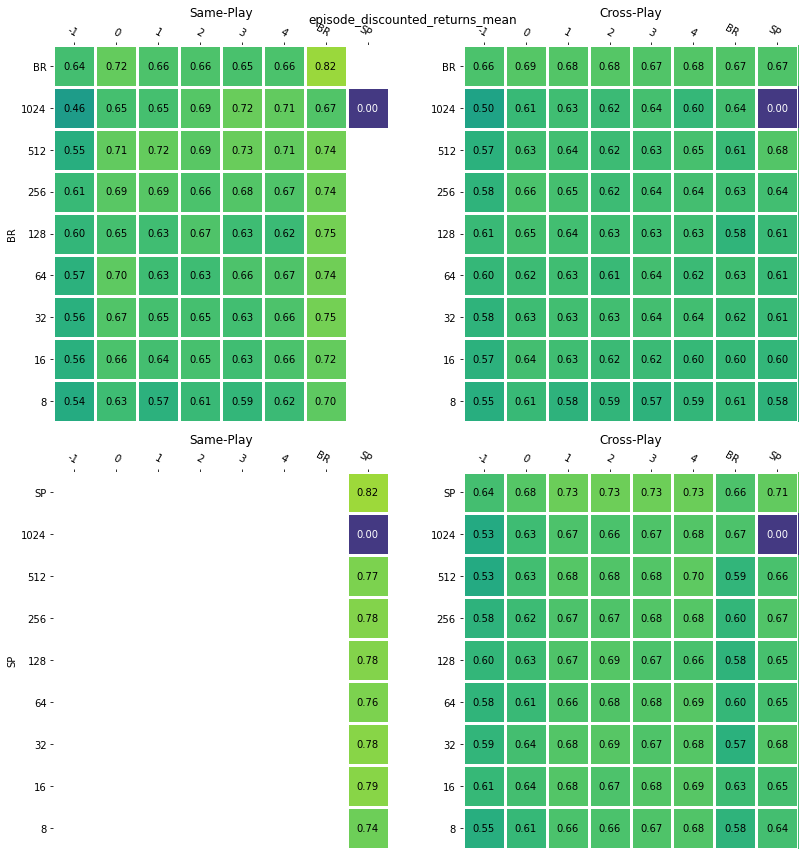

In [42]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="episode_discounted_returns_mean", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 12)
)
plt.show()

The following shows performance of BAPOSGMCP for each co-player policy with error bars.

#### Outer dimensions

- Each row of plots is a different `rollout policy`
- Each column of plots is a different `co-player policy`

#### Inner dimensions (each individual plot)

- The x-axis is `num sims`: number of simulations used by BA-POSGMCP
- The y-axis is the `episode_discounted_returns_mean` of BA-POSGMCP
- The z-axis (each line) corresponds to a different thing:
   - `XP-BA` = "Cross-play BAPOSMCP", performance of BAPOSGMCP against non-training population
   - `XP-RO` = "Cross-play Rollout Only policy", performance of the Rollout policy against non-training population
   - `SP-BA` = "Same-play BAPOSGMCP", performance of BAPOSGMCP against training population
   - `SP-RO` = "Same-play Rollout Only policy", performance of the Rollout policy against training population

rollout_Ks=['BR', 'SP']
Getting RL comparison values and errs
rl_Ks=['-1', '0', '1', '2', '3', '4', 'BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
  i=0 cp_K='-1'
  i=1 cp_K='0'
  i=2 cp_K='1'
  i=3 cp_K='2'
  i=4 cp_K='3'
  i=5 cp_K='4'
  i=6 cp_K='BR'
  i=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
  i=0 cp_K='-1'
  i=1 cp_K='0'
  i=2 cp_K='1'
  i=3 cp_K='2'
  i=4 cp_K='3'
  i=5 cp_K='4'
  i=6 cp_K='BR'
  i=7 cp_K='SP'


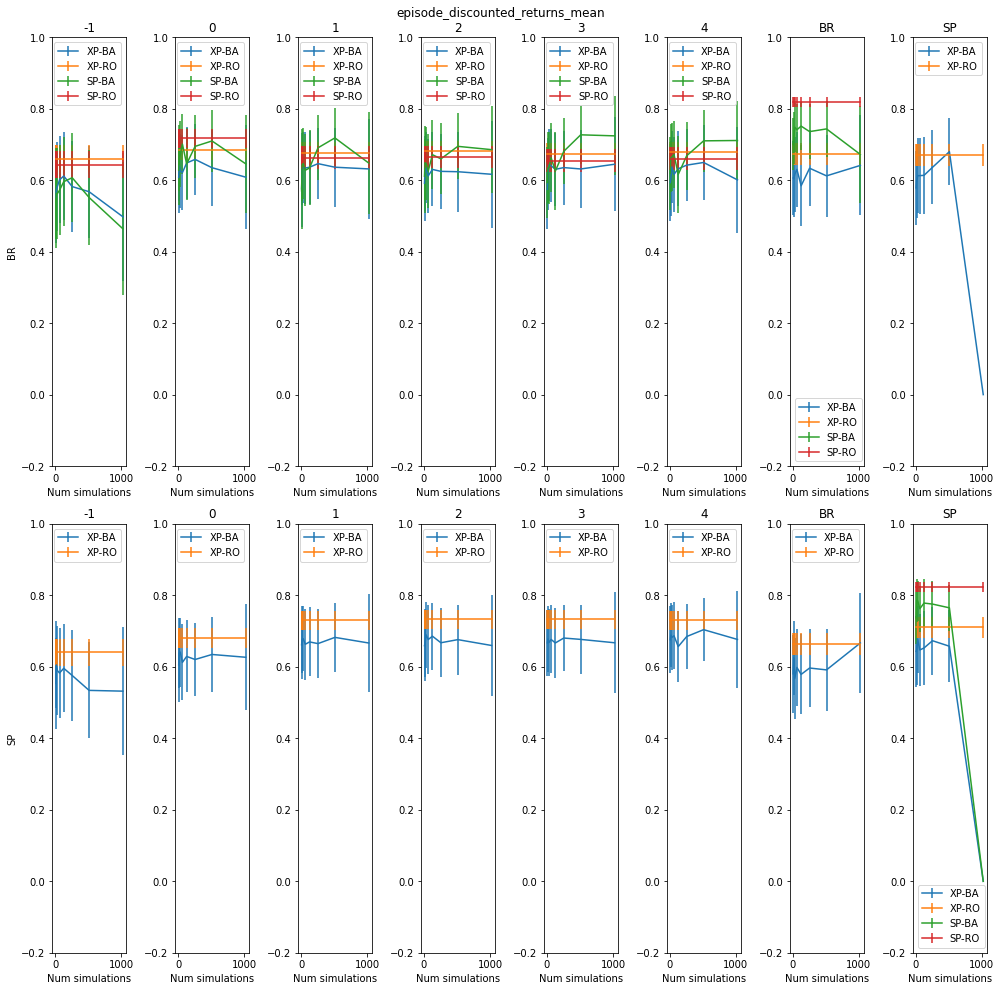

In [31]:
lineplot_ba_values_by_rollout_K(
    ba_df, 
    y_key="episode_discounted_returns_mean",
    y_err_key="episode_discounted_returns_CI",
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(14, 14)
)
plt.show()

### Results summary

Unfortunately, it's hard to say anything conclusive due to the high variation. However, from these results it appears that adding search does not, in general, improve the performance of the RL only rollout policy.

### Some more plots

1. Collision rate
2. Episode time (does not account for possibly different number of steps per episode)
3. Number of episodes completed for evaluation
4. Mean search time per step versus number of simulations
5. Accuracy of belief about the other agent's policy.

rollout_Ks=['BR', 'SP']
rl_Ks=['-1', '0', '1', '2', '3', '4', 'BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


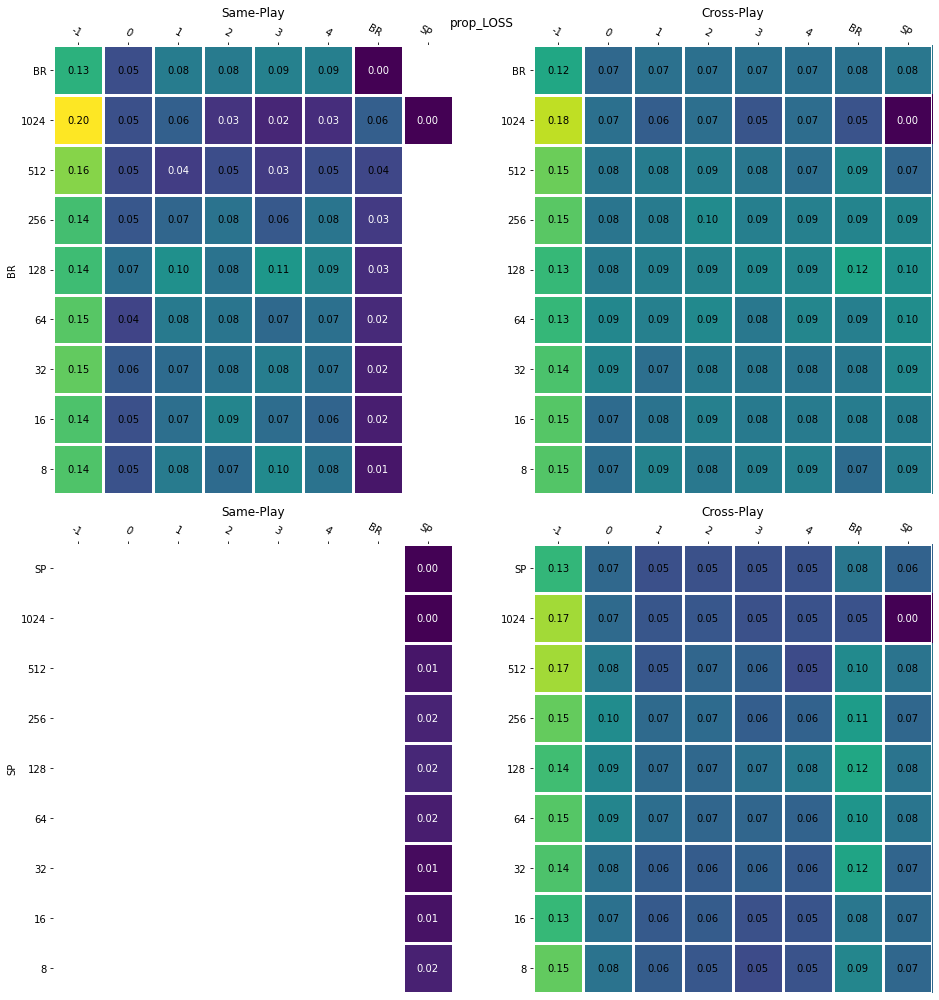

In [43]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="prop_LOSS", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(0.0, 0.2),
    figsize=(14, 14)
)
plt.show()

rollout_Ks=['BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


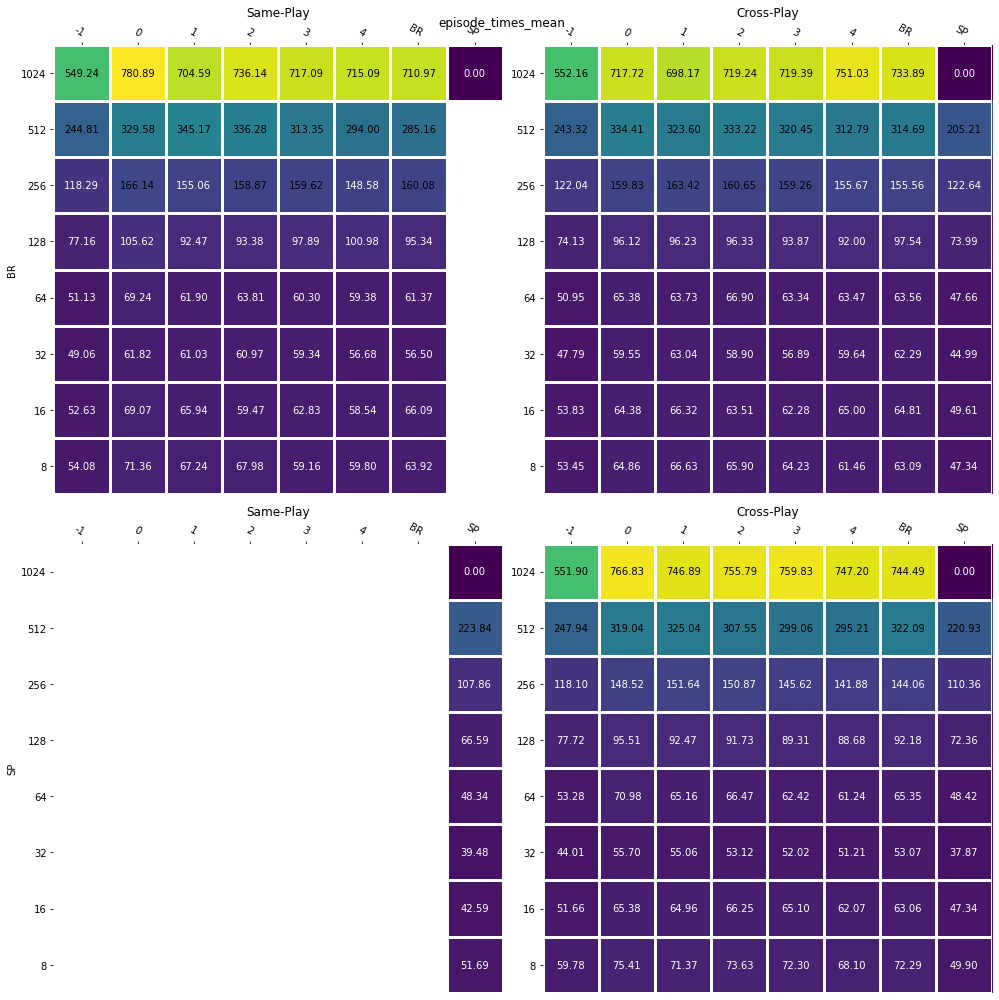

In [44]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="episode_times_mean", 
    include_rl_comparison=False, 
    plot_rl_df=None,
    vrange=None,
    figsize=(14, 14)
)
plt.show()

rollout_Ks=['BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


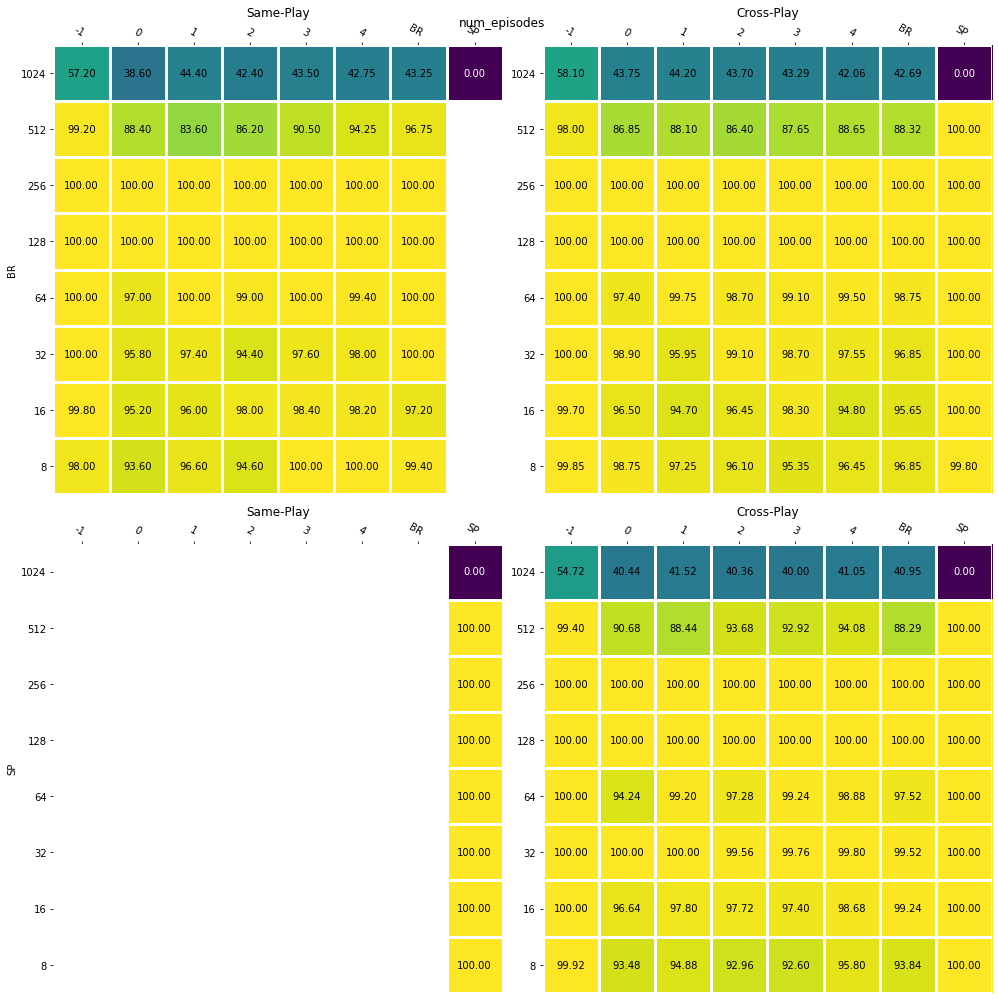

In [45]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="num_episodes", 
    include_rl_comparison=False, 
    plot_rl_df=None,
    vrange=None,
    figsize=(14, 14)
)
plt.show()

rollout_Ks=['BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


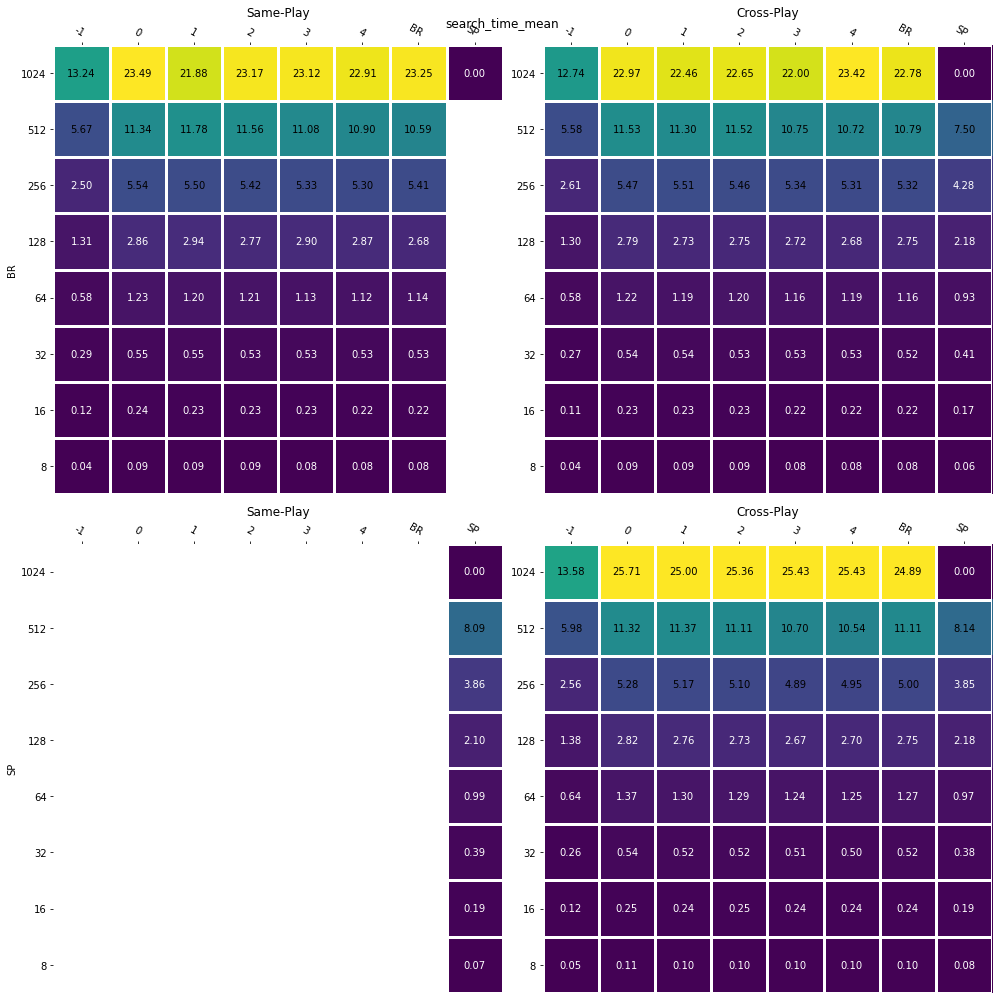

In [46]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="search_time_mean", 
    include_rl_comparison=False, 
    plot_rl_df=None,
    vrange=None,
    figsize=(14, 14)
)
plt.show()

rollout_Ks=['BR', 'SP']
row=0 rollout_K='BR'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'
row=1 rollout_K='SP'
Missing data for r=7 r_num_sims=1024 c=7 cp_K='SP'


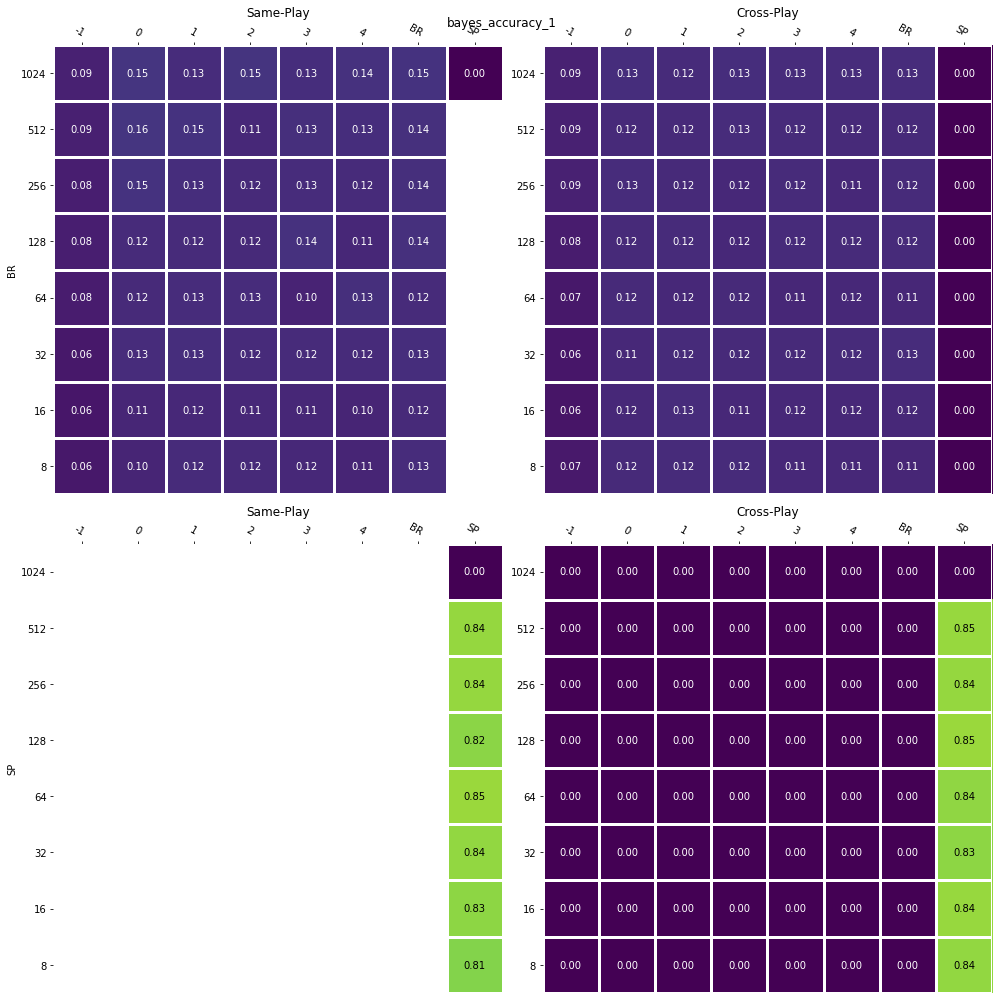

In [47]:
plot_ba_values_by_rollout_K(
    ba_df, 
    y_key="bayes_accuracy_1", 
    include_rl_comparison=False, 
    plot_rl_df=None,
    vrange=(0.0, 1.0),
    figsize=(14, 14)
)
plt.show()